## Makemore_MLP_Part4
# becoming a backprop ninja
We will write the back propagation manually

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [47]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [48]:
# build the vocab of characters and amppings to/from integers
chars = sorted(list(set(''.join(words))))
s2i = {s:i+1 for i, s in enumerate(chars)}
s2i['.'] = 0
i2s = {i:s for s, i in s2i.items()}
vocab_size = len(i2s)
print(i2s)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [49]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:

        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            idx = s2i[ch]
            X.append(context)
            Y.append(idx)
            #print(''.join(i2s[i] for i in context), '-->', i2s[idx])
            context = context[1:] + [idx] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xtst, Ytst = build_dataset(words[n2:]) # 10%

In [6]:
# biolerplate done, now we get to the action:
# ------------------------------------------------------------------------------------------

In [50]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item() # t.grad is the pytorch gradients
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [8]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1 # setting them small to make the initial loss reasonable
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

# NOTE: here the initializating are not in standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

4137


In [9]:
# calculate a single batch
batch_size = 32
n = batch_size
# construct a minibatch
idx = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
Xb, Yb = Xtr[idx], Ytr[idx] # batch X, Y

In [23]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear Layer 1
hprebn = embcat @ W1 + b1 
# BatchNorm Layer
bnmeani = 1/n * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff ** 2
bnvar = 1/(n-1) * (bndiff2).sum(0, keepdim=True) # note: Bessel's correction (divided by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**(-0.5)
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear Layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits))
logits_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logits_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0/counts_sum) instead the I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# Pytorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logits_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
          embcat, emb]:
    t.retain_grad()
loss.backward()
loss


tensor(3.3814, grad_fn=<NegBackward0>)

$$
    hpreact = bngain \cdot bndiff \cdot \frac{n-1}{\sqrt{\sum_{i} (bndiff2)_i + 1e-5}} + bnbias
$$


In [11]:
# ---------------NOTES FOR MANUALLY CALCULATING BACKPROP--------
# loss = -(a + b + c)/3
# dloss/da = -1/3
# dloss/dn = -1/n

# counts_sum = counts.sum(1, keepdim=True)
# example
# a11 a12 a13 ---> b1 (=a11 + a12 + a13)
# a21 a22 a23 ---> b2 (=a21 + a22 + a23)
# a31 a32 a33 ---> b3 (=a31 + a32 + a33)
# b1 over a21 a22... a33 is 0
# b1 over a11 a12 a13... all 1, horizontally

# interesting facts about backprop logits_maxes = logits.max(1, keepdim=True).values
# logits.max give both max values as well as their indexes
# for forward pass, we need values, but backprop will use the indexes

# matrix multiplication backpropagation
# d = a @ b + c
# [d^11 d^12] = [a^11 a^12][b^11 b^12] + [c1 c2]
# [d^21 d^11] = [a^21 a^22][b^21 b^22] + [c1 c2]
# d^11 = a^11b^11 + a^12b^21 + c1
# d^12 = a^11b^12 + a^12b^22 + c2
# d^21 = a^21b^11 + a^22b^21 + c1
# d^22 = a^21b^12 + a^22b^22 + c2


In [31]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = probs**-1 * dlogprobs # apply chain rule here
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True) # again, chain rule! here also broadcasting sum 
dcounts = counts_sum_inv * dprobs # no additional summation here
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
# dnorm_logits = norm_logits.exp() * dcounts # this can be re-write as
dnorm_logits = (counts) * dcounts
# norm_logits = logits - logits_maxes # subtract max for numerical stability
dlogits = (1 * dnorm_logits).clone() # this is not the end, because logits_maxes is a function of logits
dlogits_maxes = ((-1)*dnorm_logits).sum(1, keepdim=True) # !!broadcasting in it
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogits_maxes
dh =  dlogits @ W2.T # shape same as h
dW2 = h.T @ dlogits # shape same as W2
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True) # shape(1x32) 
dbnvar = (-0.5 * (bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone() # to be save, we do deep copy
dbnmeani = (-torch.ones_like(bndiff) * dbndiff).sum(0)
dhprebn += 1/n*(torch.ones_like(hprebn) * dbnmeani) # broadcasting * 1/n
dembcat = dhprebn @ W1.T 
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
X_e = F.one_hot(Xb.flatten(), num_classes=27).float().permute(1,0) # Convert the selection operation into a selection matrix(emb=C[Xb] <-> X_e @ C)
dC = X_e @ demb.view(-1, demb.shape[2]) # differentiate like any other matrix operation
# cmp('logprobs', dlogprobs, logprobs)
# cmp('probs', dprobs, probs)
# cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
# cmp('counts_sum', dcounts_sum, counts_sum)
# cmp('counts', dcounts, counts)
# cmp('norm_logits', dnorm_logits, norm_logits)
# cmp('logits_maxes', dlogits_maxes, logits_maxes)
# cmp('logits', dlogits, logits)
# cmp('h', dh, h)
# cmp('W2', dW2, W2)
# cmp('b2', db2, b2)
# cmp('hpreact', dhpreact, hpreact)
# cmp('bngain', dbngain, bngain)
# cmp('bnbias', dbnbias, bnbias)
# cmp('bnraw', dbnraw, bnraw)
# cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
# cmp('bnvar', dbnvar, bnvar)
# cmp('bndiff2', dbndiff2, bndiff2)
# cmp('bndiff', dbndiff, bndiff)
cmp('hprebn', dhprebn, hprebn)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

hprebn          | exact: True  | approximate: True  | maxdiff: 0.0
bnmeani         | exact: True  | approximate: True  | maxdiff: 0.0
embcat          | exact: True  | approximate: True  | maxdiff: 0.0
W1              | exact: True  | approximate: True  | maxdiff: 0.0
b1              | exact: True  | approximate: True  | maxdiff: 0.0
emb             | exact: True  | approximate: True  | maxdiff: 0.0
C               | exact: True  | approximate: True  | maxdiff: 0.0


In [13]:
h.shape, dlogits.shape, W2.shape, b2.shape


(torch.Size([32, 64]),
 torch.Size([32, 27]),
 torch.Size([64, 27]),
 torch.Size([27]))

In [32]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge, look at the mathematical expression of the loss
# take the derivative, simplify the expression, and just write it out

loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())


3.381361484527588 diff: -4.76837158203125e-07


In [33]:
# backward pass
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # only approx to be true, my maxdif is 7e-9

logits          | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


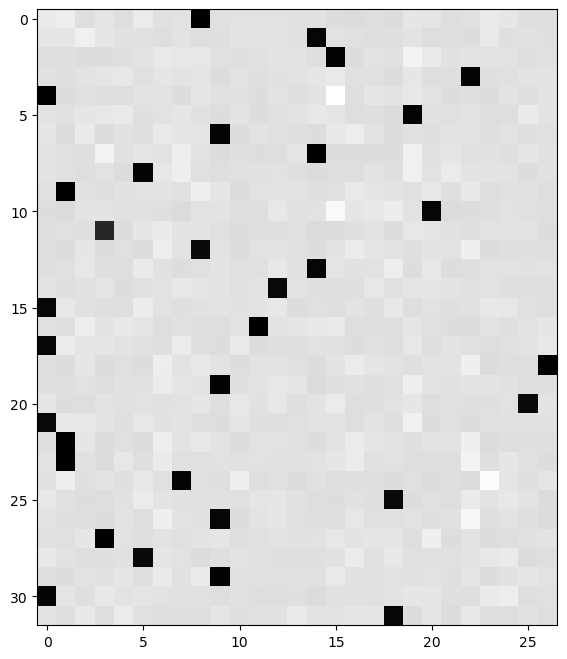

In [34]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')
# observation: 

In [36]:
# Exercise 3: batch norm layer backward pass
# look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# now with one formula
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True))/torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max_diff:', (hpreact_fast - hpreact).abs().max())

max_diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [37]:
# backward pass

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
dhprebn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1) * bnraw * (dhpreact * bnraw).sum(0)) 
cmp('hpren', dhprebn, hprebn)

# calculate dhprebn given dhpreact( i.e. backprop through the batchnorm)


hpren           | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [38]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

In [54]:
# Exercise 4: putting all together!
# Train the MLP neural network with your own backward pass

# init
n_embd = 10 # the dimensionality of the char embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),             generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1 # setting them small to make the initial loss reasonable
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

# same optimazations as last time
max_steps = 200000
batch_size = 32
lossi = []

with torch.no_grad():
    for i in range(max_steps):

        # minibatch construct
        idx = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
        Xb, Yb = Xtr[idx], Ytr[idx] # batch X, Y

        # forward pass
        emb = C[Xb] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
        # Linear layer
        hprebn = embcat @ W1 + b1 # hidden layer pre-activation, no need since we have bnbias
        # BatchNorm layer
        # --------------------------------------------------------
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # ----------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) # loss function

        # backward pass
        for p in parameters:
            p.grad = None # initialization
        #loss.backward() # use this for correctness comparisons, delete it later!

        # ----------------------------------------------------------
        # manual backprop!
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n
        # 2nd layer backprop
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        # tranh
        dhpreact = (1.0 - h**2)*dh
        # batchnorm prop
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)
        dhprebn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
        # 1st layer
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        # embedding
        demb = dembcat.view(emb.shape)
        X_e = F.one_hot(Xb.flatten(), num_classes=27).float().permute(1,0) # Convert the selection operation into a selection matrix(emb=C[Xb] <-> X_e @ C)
        dC = X_e @ demb.view(-1, demb.shape[2]) 
        #dC, dW1, db1, dW2, db2, dbngain, dbnbias = 
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
        # -----------------------------------------------------------

        # update status
        lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
        for p, grad in zip(parameters, grads):
            #p.data += -lr * p.grad
            p.data += -lr * grad
        
        # track status
        if i % 10000 == 0: # print every once in a while
            print(f'{i: 7d}/{max_steps:7d} : {loss.item(): .4f}')
        lossi.append(loss.log10().item())

        # DEBUG
        # if i >= 100:
        #     break


12297
      0/ 200000 :  3.7549
  10000/ 200000 :  2.1602
  20000/ 200000 :  2.3287
  30000/ 200000 :  2.4358
  40000/ 200000 :  1.9635
  50000/ 200000 :  2.5036
  60000/ 200000 :  2.4507
  70000/ 200000 :  1.9636
  80000/ 200000 :  2.2574
  90000/ 200000 :  2.0013
 100000/ 200000 :  2.0882
 110000/ 200000 :  2.3371
 120000/ 200000 :  1.9834
 130000/ 200000 :  2.4619
 140000/ 200000 :  2.4444
 150000/ 200000 :  2.1868
 160000/ 200000 :  1.9988
 170000/ 200000 :  1.8953
 180000/ 200000 :  2.0620
 190000/ 200000 :  1.8842


In [55]:
# # useful for checking your gradients
# for p, g in zip(parameters, grads):
#     cmp(str(tuple(p.shape)), g, p)

In [56]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [57]:
# evaluate the traing and val loss

@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': {Xtst, Ytst},
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1135826110839844
val 2.1383745670318604
